# How to identify groups of articles relevant to a specific news event

Here we provide a demo of the temporal community detection procedure applied to an example event. The approach collects the groups of articles that are both well connected and exhibit similar patterns of page views to some specified seed articles.

Note that data collection is not performed from scratch in this demo version, but the doc will be updated.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.preprocessing import RobustScaler
import WikiNewsNetwork as wnn

## 1. Data collection

N.B. This section incomplete at present and does not collect data from scratch.

Take a sample event with hyperlinked Wikipedia articles and an event date. e.g.:

_2018/11/30 ___[2018 Anchorage earthquake](https://en.wikipedia.org/wiki/2018_Anchorage_earthquake)___: A ___[magnitude](https://en.wikipedia.org/wiki/Moment_magnitude_scale)___ 7.0 earthquake hits Alaska, with the epicenter in ___[Anchorage](https://en.wikipedia.org/wiki/Anchorage,_Alaska)___. Severe damage is reported._

In [2]:
core = ['2018_Anchorage_earthquake', 'Moment_magnitude_scale', 'Anchorage,_Alaska']

Collect clickstream network data for period (download first if necessary).

In [3]:
# Pre-collected data, will be updated to collect from scratch
el = pd.read_hdf('demo/edgelist.h5')
display(el.head())

,prev,curr,n_2018-10,n_2018-11,n_2018-12,n
1,1556_Shaanxi_earthquake,Lists_of_earthquakes,4.516129,111.0,147.096774,262.612903
4,1556_Shaanxi_earthquake,Seismic_magnitude_scales,1.709677,65.0,62.903226,129.612903
11,1700_Cascadia_earthquake,1906_San_Francisco_earthquake,5.870968,112.0,149.032258,266.903226
12,1700_Cascadia_earthquake,2004_Indian_Ocean_earthquake_and_tsunami,3.032258,54.0,82.258065,139.290323
13,1700_Cascadia_earthquake,List_of_earthquakes_in_the_United_States,3.064516,72.0,125.806452,200.870968


Collect page view data for relevant articles in period.

In [4]:
# Pre-collected data, will be updated to collect from scratch
ts = pd.read_hdf('demo/timeseries.h5')
display(ts.head())

,1556_Shaanxi_earthquake,1693_Sicily_earthquake,1700_Cascadia_earthquake,1755_Lisbon_earthquake,1857_Fort_Tejon_earthquake,1886_Charleston_earthquake,1906_San_Francisco_earthquake,1908_Messina_earthquake,1925_serum_run_to_Nome,1946_Aleutian_Islands_earthquake,...,"Wasilla,_Alaska",We_Are_the_World,We_Are_the_World_25_for_Haiti,West_Coast_of_the_United_States,Western_Collegiate_Hockey_Association,White_Americans,"Whittier,_Alaska",William_H._Seward,Winter_solstice,Yup'ik
2018-10-31,285.0,39.0,306.0,1356.0,89.0,70.0,1458.0,139.0,328.0,94.0,...,242.0,3060.0,551.0,1326.0,118.0,3391.0,216.0,698.0,1479.0,79.0
2018-11-01,269.0,54.0,284.0,2687.0,48.0,71.0,1296.0,136.0,239.0,85.0,...,252.0,3295.0,596.0,1289.0,127.0,3810.0,244.0,624.0,1454.0,88.0
2018-11-02,255.0,52.0,262.0,1225.0,77.0,89.0,1405.0,112.0,285.0,61.0,...,215.0,3824.0,663.0,1305.0,142.0,4169.0,247.0,671.0,1366.0,69.0
2018-11-03,185.0,34.0,215.0,772.0,40.0,72.0,1187.0,103.0,227.0,44.0,...,240.0,4575.0,680.0,1059.0,261.0,5537.0,230.0,564.0,1185.0,92.0
2018-11-04,226.0,34.0,243.0,758.0,67.0,136.0,1216.0,98.0,273.0,44.0,...,249.0,5171.0,729.0,1176.0,238.0,3830.0,230.0,597.0,1938.0,72.0


Collect relevant redirects.

In [5]:
# Not relevant here, encouraged if collecting own data through clickstream/dumps/API

## 2. Processing

Pre-process network and pageview data

In [42]:
# Scale page view data
scaler = RobustScaler()
timeseries = scaler.fit_transform(ts)

# Filter edgelist 
el = el[el['n']>100]
el = el[(el['prev'].isin(ts.columns)) & (el['curr'].isin(ts.columns))]

# Convert to unweighted, undirected adjacency matrix
articles = sorted(set(el['prev']) | set(el['curr']))
network = (~el.pivot(index='prev', columns='curr', values='n').isna()
               ).reindex(columns=articles, index=articles, fill_value=False)
network = (network | network.T).astype(int)

Save network and page view data

In [7]:
np.save('demo/scaled_timeseries.npy', timeseries)
network.to_hdf('demo/adj.h5', key='df')

## 3. Community detection

Supply network and page view data to temporal community detection algorithm. The algorithm identifies groups of articles that are both well connected and exhibit similar attention dynamics around the time of the event.

In [15]:
# Load data if necessary
# timeseries = np.load('demo/scaled_timeseries.npy')
# network = pd.read_hdf('demo/adj.h5')

cd_output, nodename_dict = wnn.cd.cd_demo(timeseries, network, res=0.25, tau=1)
# see docs for many more arguments to this function

/Users/Patrick/Documents/OII/Project/Code/SC1/WikiNewsNetwork-01-WikiNewsTopics/WikiNewsNetwork/processing.py:272: RuntimeWarning: invalid value encountered in true_divide
  xmn = xm/np.sqrt((xm*xm).sum(axis=0))


Process community detection output:

In [16]:
membership_df = pd.concat([pd.Series(x, index=nodename_dict[n])
                            for n, x in enumerate(cd_output[0])],
                           axis=1, sort=True)
display(membership_df)

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
1556_Shaanxi_earthquake,93,93,93,93,93,93,93,93,93,93,...,18,18,7,7,7,7,7,7,7,7
1693_Sicily_earthquake,150,150,150,150,150,150,150,150,150,150,...,150,150,150,150,150,150,150,150,150,150
1700_Cascadia_earthquake,93,93,93,52,52,120,120,120,0,0,...,18,18,7,7,7,7,7,7,7,7
1755_Lisbon_earthquake,394,394,394,394,394,394,394,394,394,394,...,18,18,7,7,7,7,7,7,7,7
1857_Fort_Tejon_earthquake,274,274,274,274,274,274,274,274,274,274,...,146,146,146,146,146,146,146,388,388,388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
White_Americans,191,191,191,191,191,191,30,30,30,30,...,151,151,151,151,151,151,47,47,47,47
"Whittier,_Alaska",149,149,149,149,149,149,211,211,211,211,...,15,15,15,15,15,15,15,15,15,15
William_H._Seward,22,22,22,22,22,22,22,22,22,22,...,22,22,22,117,117,117,22,22,22,22
Winter_solstice,264,264,57,57,57,57,57,57,57,57,...,35,35,35,35,35,35,35,35,35,35


Extract 'Event Reactions' - communities overlapping with event date (column 27) containing at least one of the previously specified core articles. We have identified the groups of articles related to the event!

In [17]:
ev_reactions = wnn.cd.extract_event_reactions(membership_df, core, list(membership_df.index))
for k, v in ev_reactions.items():
    print(k)
    display(v) # NaN simply indicates not part of the community for this timestep

Moment_magnitude_scale


,25,26,27,28
1556_Shaanxi_earthquake,32.0,32.0,32.0,32.0
1700_Cascadia_earthquake,32.0,32.0,32.0,32.0
1755_Lisbon_earthquake,32.0,NaN,NaN,NaN
1906_San_Francisco_earthquake,32.0,32.0,32.0,32.0
1960_Valdivia_earthquake,32.0,32.0,32.0,32.0
1989_Loma_Prieta_earthquake,32.0,32.0,32.0,32.0
1994_Northridge_earthquake,32.0,32.0,32.0,32.0
2004_Indian_Ocean_earthquake_and_tsunami,32.0,32.0,32.0,32.0
2014_South_Napa_earthquake,32.0,32.0,32.0,32.0
2016_Oklahoma_earthquake,NaN,NaN,NaN,32.0


2018_Anchorage_earthquake


,26,27,28
1964_Alaska_earthquake,NaN,41.0,41.0
2001_Nisqually_earthquake,41.0,41.0,41.0
2011_Virginia_earthquake,41.0,41.0,41.0
2012_Indian_Ocean_earthquakes,41.0,NaN,NaN
2018_Alaska_earthquake,41.0,41.0,41.0
2018_Anchorage_earthquake,41.0,41.0,41.0
2018_Gulf_of_Alaska_earthquake,41.0,41.0,41.0
Alaska_Time_Zone,NaN,41.0,41.0
Aleutian_Trench,NaN,41.0,41.0
Fault_(geology),41.0,41.0,41.0


Anchorage,_Alaska


,26,27,29
Alaska,15.0,15.0,15.0
Alaska_Natives,15.0,15.0,15.0
Alaska_Railroad,NaN,NaN,15.0
"Anchorage,_Alaska",15.0,15.0,15.0
Climate_of_Alaska,NaN,NaN,15.0
Demographics_of_Alaska,15.0,15.0,15.0
"Fairbanks,_Alaska",15.0,15.0,15.0
"Fire_Island_(Anchorage,_Alaska)",NaN,15.0,NaN
Interior_Alaska,15.0,15.0,15.0
"Juneau,_Alaska",15.0,15.0,15.0


## 4. Visualisation

A quick look at the page view time series for each community

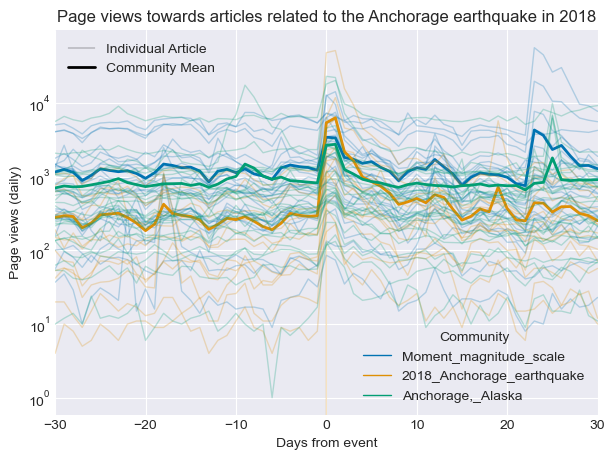

In [41]:
# set style
plt.style.use('seaborn-darkgrid')
palette = sns.color_palette('colorblind', len(ev_reactions))

# alter x values
tsp = ts.copy()
tsp.index = (tsp.index - tsp.index[len(tsp)//2]).days

# plot page views for each community
fig, ax = plt.subplots(figsize=(7,5))
for n, (k, v) in enumerate(ev_reactions.items()):
    ax.plot(tsp[v.index], lw=1, alpha=0.25, c=palette[n])
    ax.plot(tsp[v.index].mean(axis=1), lw=2, c=palette[n])

# add legends
legend_elements1 = [Line2D([0], [0], color='k', lw=0.25,
                           label='Individual Article'),
                    Line2D([0], [0], color='k', lw=2,
                           label='Community Mean')]
legend_elements2 = [Line2D([0], [0], color=palette[n], lw=1,
                           label=k)
                    for n, k in enumerate(ev_reactions.keys())] 
l1 = ax.legend(handles=legend_elements1, loc=2)
l2 = ax.legend(handles=legend_elements2, title='Community', loc=4)
ax.add_artist(l1)

# tune other elements
ax.set_ylabel('Page views (daily)')
ax.set_xlabel('Days from event')
ax.set_xlim(-30, 30)
ax.set_yscale('log')
ax.set_title('Page views towards articles related to the Anchorage earthquake in 2018')
plt.show()